# Agregado del dataset a Google Drive propio

In [ ]:
#ORIGINAL: https://colab.research.google.com/github/deeplearning-itba/FAT2019-Reducida/blob/master/ITBA_AUDIO_Classification.ipynb#scrollTo=n5e7TpOyJ0Um

In [ ]:
!pip install librosa==0.8.1 # y restartear kernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


Hacer click en el siguiente link:

https://drive.google.com/file/d/1I3yWgx9HC-TEmfRr6hgB_dZPcy7qhrZK/view?usp=sharing

Agregarlo a tu drive con el icono de '+'


# Login a Drive, unzip y bajada de librería

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/My Drive/audios_itba.zip" > /dev/null

In [ ]:
! wget https://raw.githubusercontent.com/deeplearning-itba/FAT2019-Reducida/master/freesound_helper.py

--2023-08-16 12:31:05--  https://raw.githubusercontent.com/deeplearning-itba/FAT2019-Reducida/master/freesound_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22500 (22K) [text/plain]
Saving to: ‘freesound_helper.py.1’

freesound_helper.py 100%[===================>]  21.97K  --.-KB/s    in 0.002s  

2023-08-16 12:31:05 (13.0 MB/s) - ‘freesound_helper.py.1’ saved [22500/22500]



# Carga y análisis de dataset
Si ya tiene cargado el dataset puede arrancar desde aca despues de restart runtime

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa

In [ ]:
DATA = Path('ITBA_dataset/')
AUDIOS_FOLDER = DATA/'audios'

In [ ]:
annotations = pd.read_csv(DATA/'train.csv')[['fname', 'labels']]

In [ ]:
annotations.head()

,fname,labels
0,001ec0ad.wav,Finger_snapping
1,0026f116.wav,Finger_snapping
2,0217540b.wav,Zipper_(clothing)
3,030d5b55.wav,Finger_snapping
4,037b9243.wav,Marimba_and_xylophone


In [ ]:
from collections import Counter
Counter(annotations['labels'])

Counter({'Finger_snapping': 75,
         'Zipper_(clothing)': 75,
         'Marimba_and_xylophone': 75,
         'Keys_jangling': 75,
         'Skateboard': 75,
         'Computer_keyboard': 75,
         'Printer': 75,
         'Gong': 75,
         'Scissors': 75})

**Misma cantidad de muestras para cada clase (75 c/una). Ok**

In [ ]:
# Nos quedamos con las categorías
categories = np.array(list(set(annotations['labels'])))
print(categories)

['Printer' 'Finger_snapping' 'Marimba_and_xylophone' 'Skateboard'
 'Scissors' 'Computer_keyboard' 'Zipper_(clothing)' 'Keys_jangling' 'Gong']


**9 categorias diferentes**

In [ ]:
# ONE HOT ENCONDIG
y_train = np.vstack(annotations['labels'].apply(lambda x: x.split(',')).apply(lambda x: np.isin(categories, x))).astype(int)
# Formateamos lectura de files
X_train = annotations['fname'].apply(lambda x: AUDIOS_FOLDER/x).values

In [ ]:
y_train # vectores de clase, en ONE-HOT-ENCODING

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Escuchamos audios
i = 11 # Indice del audio a escuchar
X_i, sr = librosa.load(X_train[i], sr=None)
print(np.array(categories)[np.array(y_train[i]).astype(bool)])
ipd.Audio(X_i.reshape(-1), rate=sr)

['Marimba_and_xylophone']


# Importamos Generator y graficamos salida (MEL Spectrogram)

In [ ]:
from freesound_helper import DataGeneratorMel

In [ ]:
# Split train/val
np.random.seed(42)
indexes = np.arange(len(X_train))
np.random.shuffle(indexes)
tr_cut = int(np.round(len(indexes)*0.8))

In [ ]:
# Hyperparámetros
audio_duration = 2
sample_rate = int(44100)
batch_size = 32
n_fft = 2048
hop_length = 4*256

In [ ]:
dataGen_train_mel = DataGeneratorMel(X_train[indexes[:tr_cut]], y_train[indexes[:tr_cut]], None,
                              batch_size=batch_size, audio_duration=audio_duration, sample_rate=sample_rate,
                                     hop_length=hop_length, n_fft=n_fft)
dataGen_val_mel = DataGeneratorMel(X_train[indexes[tr_cut:]], y_train[indexes[tr_cut:]], None,
                            batch_size=batch_size, audio_duration=audio_duration, sample_rate=sample_rate,
                                   hop_length=hop_length, n_fft=n_fft)

In [ ]:
%time X_mel, y_mel = dataGen_train_mel[0]

CPU times: user 489 ms, sys: 580 ms, total: 1.07 s
Wall time: 1.17 s


In [ ]:
X_mel.shape, y_mel.shape

((32, 128, 87, 1), (32, 9))

['Printer']


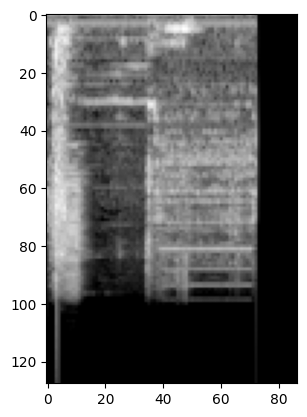

(128, 87, 1)
1.4628571428571429


In [ ]:
# Visualización de salida de generator
i = 4
print(categories[np.where(y_mel[i]==1)[0]])
plt.imshow(X_mel[i].reshape(X_mel[i].shape[:2]), cmap='gray')
plt.show()
print(X_mel[i].shape)
print(63 * hop_length / sample_rate)

# Armar CNN

In [ ]:
from keras.layers import Concatenate, Input, Conv1D, MaxPool1D, Flatten, Dense, GlobalAveragePooling1D, BatchNormalization, Activation, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D
from keras.models import Sequential, Model
#from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
# Hyperparámetros
audio_duration = 5
sample_rate = int(44100)
batch_size = 32
n_fft = 2048
hop_length = 4*256

In [ ]:
class DataGeneratorMel3DWithSampleClip(keras.utils.Sequence):
    """ output RGB o multiplicar pesos de cada capa """
    @staticmethod
    def sample_audio_clip(self, clip):
        fr = int(np.random.rand(1)*(len(clip)-self.chunk_samples) )
        if fr >= 0:
            to = fr + self.chunk_samples
            x = clip[fr:to]
        else:
            x = np.zeros(self.chunk_samples)
            fr = int(np.random.rand(1)*(self.chunk_samples-len(clip)))
            x[fr:fr+len(clip)] = clip
        #print(x.shape)
        return np.array(x, dtype='float32')

    @staticmethod
    def get_audio(index, X, folder, sr = 44100, duration=2, hop_length=1024, n_fft=2048):
        if folder is not None:
            audio_file = folder/X[index]
        else:
            audio_file = X[index]

        # Open file with original sample rate
        audio_samples, orig_sr = librosa.load(audio_file, sr=None)
        audio_samples = DataGeneratorMel.sample_audio_clip( audio_samples )

        if duration is not None:
            stop = int(duration*orig_sr)
            X_truncated = audio_samples[0:stop]
            X_truncated = np.hstack([X_truncated, np.zeros(stop-len(X_truncated))])
        else:
            X_truncated = audio_samples
        mel_spec = librosa.feature.melspectrogram(y=X_truncated, sr=sr, hop_length=hop_length, n_fft=n_fft)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        return mel_spec_db

    @staticmethod
    def get_batch(indexes, X, y, folder, sr = 44100, duration=2, hop_length=1024, n_fft=2048):
        batch_X = []
        batch_y = np.zeros([0, y.shape[1]])
        for i in indexes:
            if duration==0:
                duration = 2+np.random.rand()*12
            X_ = DataGeneratorMel.get_audio(i, X, folder, sr = sr, duration=duration, hop_length=hop_length, n_fft=n_fft)
            batch_X.append(X_)
            # batch_X = np.vstack([batch_X, X_])
            batch_y = np.vstack([batch_y, y[i]])
        batch_X = np.array(batch_X)
        return batch_X, batch_y

    def __init__(self, X_train, y_train, audio_folder, batch_size=128,
                 shuffle=True, random_seed=42,
                 sample_rate=44100, audio_duration=2,  hop_length=1024, n_fft=2048, TwoD=True):
        np.random.seed(random_seed)
        self.batch_size = batch_size
        self.audio_folder = audio_folder
        self.sample_rate = sample_rate
        self.audio_duration = audio_duration
        self.X_train = X_train
        self.y_train = y_train
        self.shuffle = shuffle
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.chunk_samples = audio_duration * sample_rate
        self.on_epoch_end()
        self.TwoD = TwoD
        return

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = DataGeneratorMel.get_batch(indexes, self.X_train, self.y_train, self.audio_folder,
                                       self.sample_rate, self.audio_duration, hop_length=self.hop_length, n_fft=self.n_fft)
        if self.TwoD:
            image = X.reshape(*X.shape , 1)
            image = np.repeat(image, 3, axis=-1)
            return image, y
        else:
            return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X_train))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
dataGen_train_mel = DataGeneratorMel3DWithSampleClip(X_train[indexes[:tr_cut]], y_train[indexes[:tr_cut]], None,
                              batch_size=batch_size, audio_duration=audio_duration, sample_rate=sample_rate,
                                     hop_length=hop_length, n_fft=n_fft)
dataGen_val_mel = DataGeneratorMel3DWithSampleClip(X_train[indexes[tr_cut:]], y_train[indexes[tr_cut:]], None,
                            batch_size=batch_size, audio_duration=audio_duration, sample_rate=sample_rate,
                                   hop_length=hop_length, n_fft=n_fft)

In [ ]:
num_classes = len(categories)

# Se separa el dataset en 80% train, 10% validación y 10% test

In [ ]:
file_paths = X_train # archivos wav, nombres de archivos
labels = y_train # vectores de clase, en ONE-HOT-ENCODING

In [ ]:
# Split: train, validation and test sets
split_ratio = [0.8, 0.1, 0.1]  # 80% train, 10% validation, 10% test
total_samples = len(file_paths)
train_size = int(split_ratio[0] * total_samples)
val_size = int(split_ratio[1] * total_samples)

train_file_paths = file_paths[:train_size]
val_file_paths = file_paths[train_size:train_size + val_size]
test_file_paths = file_paths[train_size + val_size:]

train_labels = labels[:train_size]
val_labels = labels[train_size:train_size + val_size]
test_labels = labels[train_size + val_size:]

In [ ]:
train_generator = DataGeneratorMel3DWithSampleClip(
                              train_file_paths,
                              train_labels,
                              None,
                              batch_size=batch_size,
                              audio_duration=audio_duration,
                              sample_rate=sample_rate,
                              hop_length=hop_length,
                              n_fft=n_fft)
val_generator = DataGeneratorMel3DWithSampleClip(
                              val_file_paths,
                              val_labels,
                              None,
                              batch_size=batch_size,
                              audio_duration=audio_duration,
                              sample_rate=sample_rate,
                              hop_length=hop_length,
                              n_fft=n_fft)
test_generator = DataGeneratorMel3DWithSampleClip(
                              test_file_paths,
                              test_labels,
                              None,
                              batch_size=batch_size,
                              audio_duration=audio_duration,
                              sample_rate=sample_rate,
                              hop_length=hop_length,
                              n_fft=n_fft)

In [ ]:

# Carga de un modelo pre-entrenado ResNet-50 model (transfer learning)
# la última capa no la quiero porque voy a tener diferente cantidad de clases de
# salida para clasificar (include_top=False)
pretrained_model = ResNet50(weights='imagenet', include_top=False)

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)

# softmax para la activación según la cantidad de clases
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=output_layer)

# como es un problema multi-clase utilizo categorical_crossentropy para la loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
num_epochs = 50

history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator)


Epoch 1/50
17/17 [==============================] - 62s 1s/step - loss: 1.8332 - accuracy: 0.5000 - val_loss: 1729.4058 - val_accuracy: 0.0448
Epoch 2/50
17/17 [==============================] - 22s 1s/step - loss: 1.0565 - accuracy: 0.6889 - val_loss: 235.5603 - val_accuracy: 0.0448
Epoch 3/50
17/17 [==============================] - 16s 932ms/step - loss: 0.7281 - accuracy: 0.8074 - val_loss: 57.4440 - val_accuracy: 0.1642
Epoch 4/50
17/17 [==============================] - 16s 933ms/step - loss: 0.5598 - accuracy: 0.8130 - val_loss: 78.1263 - val_accuracy: 0.0448
Epoch 5/50
17/17 [==============================] - 19s 1s/step - loss: 0.5091 - accuracy: 0.8500 - val_loss: 104.0389 - val_accuracy: 0.1194
Epoch 6/50
17/17 [==============================] - 19s 1s/step - loss: 0.3662 - accuracy: 0.8852 - val_loss: 11.9682 - val_accuracy: 0.2537
Epoch 7/50
17/17 [==============================] - 17s 998ms/step - loss: 0.2468 - accuracy: 0.9204 - val_loss: 6.2160 - val_accuracy: 0.2687
E

**Validation Accuracy: 0.73**

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)

print("Test Accuracy:", test_accuracy)

3/3 [==============================] - 2s 635ms/step - loss: 1.2131 - accuracy: 0.7206
Test Loss: 1.2130540609359741
Test Accuracy: 0.720588207244873


Dataset 675 archivos, 9 clases balanceadas (75 c/una).  80% train, 10% validation, 10% test
Pretrained resnet. Duration = 5 seg. 50 Epochs

**Test Accuracy: 0.72**